In [ ]:
!pip install xgboost

In [3]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [6]:
df = pd.read_csv('/content/ad_10000records.csv')
df.head()

,Daily Time Spent on Site,Age,Area Income,Daily Internet Usage,Ad Topic Line,City,Gender,Country,Timestamp,Clicked on Ad
0,62.26,32.0,69481.85,172.83,Decentralized real-time circuit,Lisafort,Male,Svalbard & Jan Mayen Islands,2016-06-09 21:43:05,0
1,41.73,31.0,61840.26,207.17,Optional full-range projection,West Angelabury,Male,Singapore,2016-01-16 17:56:05,0
2,44.40,30.0,57877.15,172.83,Total 5thgeneration standardization,Reyesfurt,Female,Guadeloupe,2016-06-29 10:50:45,0
3,59.88,28.0,56180.93,207.17,Balanced empowering success,New Michael,Female,Zambia,2016-06-21 14:32:32,0
4,49.21,30.0,54324.73,201.58,Total 5thgeneration standardization,West Richard,Female,Qatar,2016-07-21 10:54:35,1


In [7]:
df.isnull().sum()

,0
Daily Time Spent on Site,0
Age,0
Area Income,0
Daily Internet Usage,0
Ad Topic Line,0
City,0
Gender,0
Country,0
Timestamp,0
Clicked on Ad,0


In [8]:
df['Timestamp'] = pd.to_datetime(df['Timestamp'])
df['Hour'] = df['Timestamp'].dt.hour
df['DayOfWeek'] = df['Timestamp'].dt.weekday

In [21]:
le = LabelEncoder()
df['Gender'] = le.fit_transform(df['Gender'].astype(str))
df['City_Code'] = le.fit_transform(df['City'].astype(str))
df['Country_Code'] = le.fit_transform(df['Country'].astype(str))

In [22]:
X = df[['Daily Time Spent on Site', 'Age', 'Area Income',
        'Daily Internet Usage', 'Gender', 'City_Code',
        'Country_Code', 'Hour', 'DayOfWeek']]
y = df['Clicked on Ad']

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [27]:
model = xgb.XGBClassifier(
    n_estimators=100,
    max_depth=5,
    learning_rate=0.1,
    objective='binary:logistic'
)

In [28]:
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, ...)

In [29]:
from sklearn.metrics import roc_auc_score, log_loss, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

In [30]:
y_probs = model.predict_proba(X_test)[:, 1]
y_preds = model.predict(X_test)

In [31]:
print(f"ROC-AUC Score: {roc_auc_score(y_test, y_probs):.4f}")

ROC-AUC Score: 0.9328


In [32]:
print(f"Log Loss: {log_loss(y_test, y_probs):.4f}")

Log Loss: 0.3451


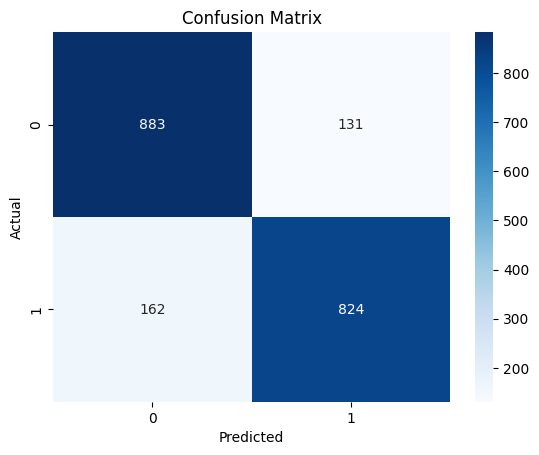

In [33]:
cm = confusion_matrix(y_test, y_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

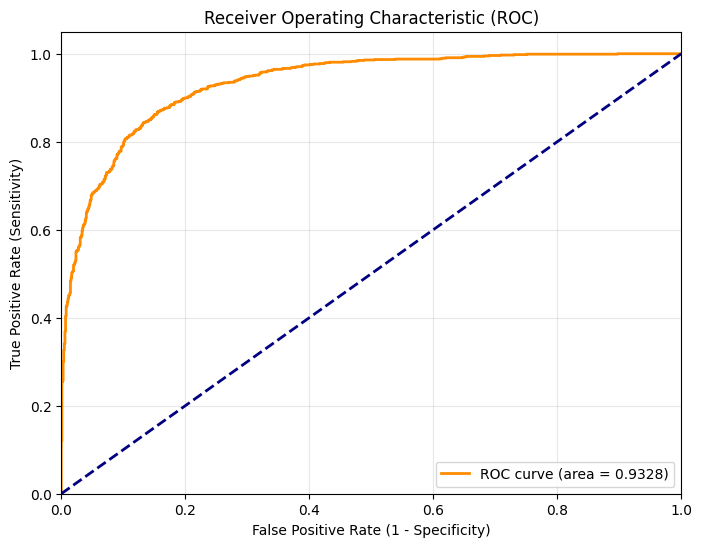

In [36]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

/tmp/ipython-input-4292437325.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_df, palette='viridis')


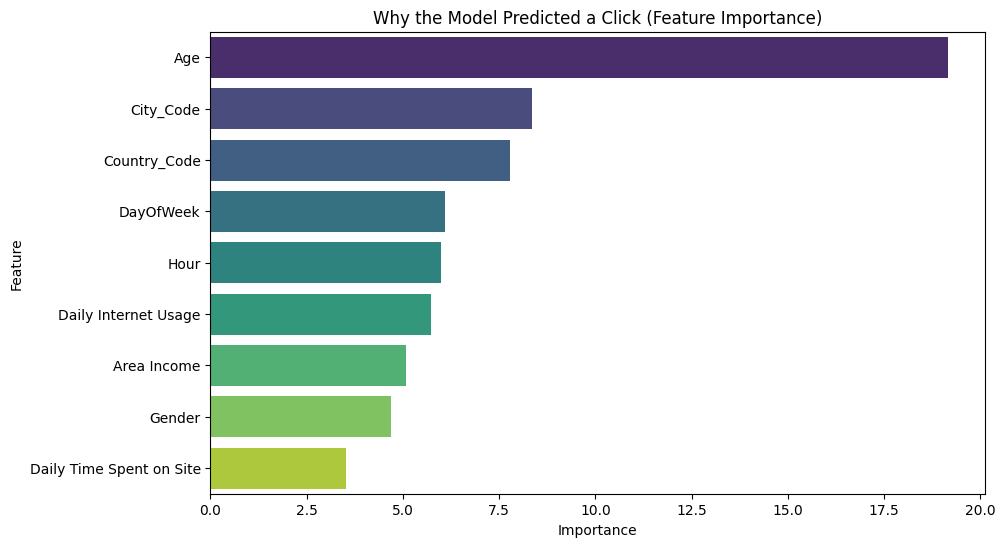

In [40]:
# Extract importances from your XGBoost model
importance_dict = model.get_score(importance_type='gain')

# Convert the dictionary to a DataFrame for Seaborn
feature_df = pd.DataFrame(list(importance_dict.items()), columns=['Feature', 'Importance'])
feature_df = feature_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_df, palette='viridis')
plt.title('Why the Model Predicted a Click (Feature Importance)')
plt.show()

In [43]:
model.save_model("ctr_model.json")